In [2]:
import os
# running from Root directory
os.chdir("..")

In [5]:
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from networks.loaders.network_loader import NetworkLoader
from utils.types import NetworkInputType, NetworkLoaderArgs
from networks.network import Network
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import Any

simple_input_args = NetworkLoaderArgs(
    synapse_threshold=1,
    filter_polarity=['+', '-', 'complex'],
    filter_prim_nt=['GABA', 'Glu', 'ACh', 0],
    filter_syn_type='chem',
    filter_sex_type='herm',
    filter_nerve_ring_neurons=True
)
loader = NetworkLoader(simple_input_args)

network = loader.load_network_file(file_path="networks/data/polarity_2020/s1_data.xlsx",
                                   input_type=NetworkInputType.polarity_xlsx)


# network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 2 Synapse adjacency matrices.xlsx",
#                                     input_type=NetworkInputType.worm_wiring_xlsx)


#network = loader.load_network_file(file_path="networks/data/Cook_2019/SI 5 Connectome adjacency matrices, corrected July 2020.xlsx",
#                                    input_type=NetworkInputType.worm_wiring_xlsx)



Network file name: s1_data.xlsx
Filtering Neurons with polarity: ['+', '-', 'complex']
Filtering Neurons with primary neurotransmitter: ['GABA', 'Glu', 'ACh', 0]
Polarity ratios (before filtering): Counter({'+': 0.5969410706252811, 'complex': 0.21187584345479082, '-': 0.19118308591992803})

Network properties:
	Neurons in the network: 285
	Participating Neurons (in the graph): 174

	Participating Nodes are neurons with at least: 1 synapses
	Synapses in the network: 10489
	Synapses in the graph: 10489
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 174
	Edges: 1403
	Average clustering coefficient: 0.189
	Average shortest path (undirected): 2.387
	Density: 0.047
	Polarity ratios: Counter({'+': 0.4896650035637919, '-': 0.27441197434069853, 'complex': 0.2359230220955096})
	Degree: Mean: 16.126 Std: 12.084 Median: 13.0 Max: 53 (node: AVAL)
	In-Degree: Mean: 8.063 Std: 9.38 Median: 5.0 Max: 43 (node: AVAL)
	Out-Degree: Mean: 8.063 Std: 5.226 Median: 7.0 Max: 25 (node: RIML)


In [46]:
# Degree per Neurons
# for node_idx, n in enumerate(network.neuron_names):
#     if node_idx not in dict(network.graph.degree):
#         d_in = d_out = 0
#     else:
#         d_in = network.graph.in_degree(node_idx)
#         d_out = network.graph.out_degree(node_idx)
#     print(f'{node_idx}: {n} in: {d_in} out: {d_out}')

In [6]:
def basic_plot(data: Any, title: str, xlabel: str, ylabel: str, plot_func: Any, log_scale=False):
    plt.figure()

    if log_scale:
        plt.yscale("log")
        plt.xscale("log")

    plot_func(*data)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

In [7]:
def plot_rich_club_coefficient(network: Network):
    un_dir_graph = nx.Graph(network.graph)
    un_dir_graph.remove_edges_from(nx.selfloop_edges(un_dir_graph))
    rc = nx.rich_club_coefficient(un_dir_graph, normalized=False, seed=42)
    data = list(rc.keys()), list(rc.values())
    basic_plot(data=data,
               title='Rich Club Coefficient',
               xlabel='Degree (k)',
               ylabel='Rich Club Coefficient',
               plot_func=plt.scatter)


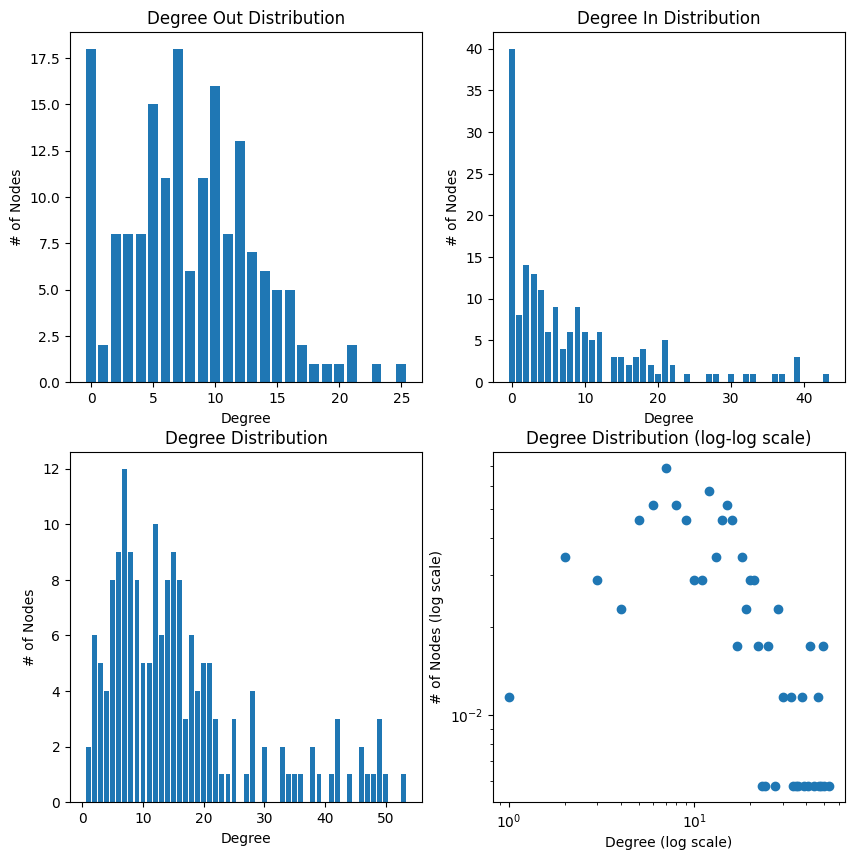

In [8]:
def _set_bar_subplot(ax, data, title, xlabel, ylabel):
    ax.bar(*data)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_degree_dist(network: Network):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    degree_sequence = sorted((d for n, d in network.graph.out_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,0], data, 'Degree Out Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.in_degree), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[0,1], data, 'Degree In Distribution', 'Degree', '# of Nodes')

    degree_sequence = sorted((d for n, d in network.graph.degree()), reverse=True)
    data = np.unique(degree_sequence, return_counts=True)
    _set_bar_subplot(ax[1,0], data, 'Degree Distribution', 'Degree', '# of Nodes')

    # Log-Log
    y = nx.degree_histogram(network.graph)
    x = np.arange(0, len(y)).tolist()
    n = network.graph.number_of_nodes()

    for i in range(len(y)):
        y[i] = y[i] / n
    
    ax[1,1].plot(x, y, 'o')
    ax[1,1].set_xscale('log')
    ax[1,1].set_xlabel('Degree (log scale)')
    ax[1,1].set_yscale('log')
    ax[1,1].set_ylabel('# of Nodes (log scale)')
    ax[1,1].set_title('Degree Distribution (log-log scale)')


plot_degree_dist(network)

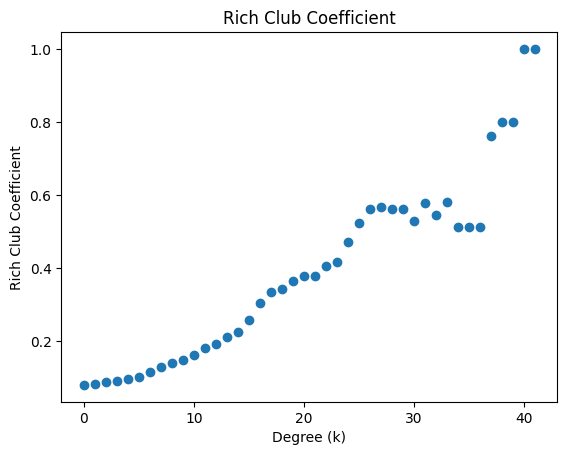

In [9]:
plot_rich_club_coefficient(network)

['ADAL', 'ADAR', 'ADLL', 'ADLR', 'AQR', 'ASHR', 'AVJR', 'DVC', 'FLPL', 'FLPR', 'AVDR']


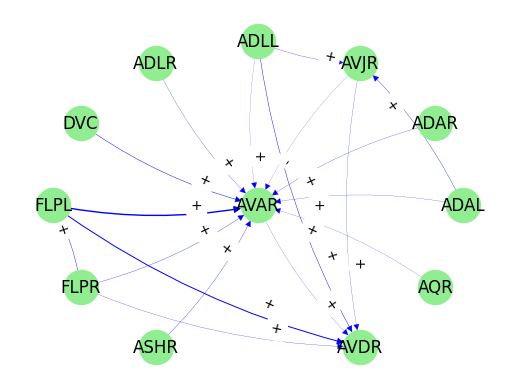

In [7]:
draw_neighbors(network, 'AVAR', 'all', False)

In [8]:
node_properties(network, 'AIAL')

Node AIAL properties:
Degree: 1
Out Degree: 1
In Degree: 0
Clustering coefficient: 0.0


nerve ring

In [9]:
from random_networks.nerve_ring_markov_chain_switching import NerveRingMarkovChainSwitching
nerve_ring = NerveRingMarkovChainSwitching(network, switch_factor=10)

nerve_ring.DISTANCE_TH = 0.1
nerve_ring.init_nerve_ring_allow_list()
nerve_ring_allow = nerve_ring.nerve_ring_allow

In [10]:
ratios = []
for n in nerve_ring_allow:
    if n not in network.neuron_names:
        # print(n)
        continue
    node_idx = network.neuron_names.index(n)
    
    if node_idx not in dict(network.graph.degree):
        print(n)
        continue

    synapses = network.graph.degree[node_idx]
    pot_synapses = len(nerve_ring_allow[n])
    ratio = synapses / pot_synapses
    print(n, synapses, pot_synapses, round(ratio,2))
    ratios.append(ratio)

ADAR 4 60 0.07
ADAL 4 50 0.08
ADEL 1 24 0.04
ADER 1 27 0.04
ADFL 3 13 0.23
ADFR 4 21 0.19
ADLL 6 32 0.19
ADLR 6 33 0.18
AFDL 1 22 0.05
AFDR 1 19 0.05
AIAL 1 30 0.03
AIAR 1 29 0.03
AIBL 18 49 0.37
AIBR 13 46 0.28
AIML
AIMR 1 41 0.02
AINL
AINR 1 41 0.02
AIYL 9 33 0.27
AIYR 8 31 0.26
AIZL 11 33 0.33
AIZR 7 33 0.21
ALA 1 50 0.02
ALML 3 16 0.19
ALMR 2 18 0.11
ALNL 1 24 0.04
ALNR
AQR 4 38 0.11
ASEL 4 32 0.12
ASER 3 41 0.07
ASGL 1 10 0.1
ASGR 2 12 0.17
ASHL 5 23 0.22
ASHR 6 20 0.3
ASJL 1 31 0.03
ASJR 1 32 0.03
ASKL 1 23 0.04
ASKR
AUAL 2 26 0.08
AUAR 1 22 0.05
AVAL 9 66 0.14
AVAR 11 60 0.18
AVBL 22 56 0.39
AVBR 20 57 0.35
AVDL 6 72 0.08
AVDR 6 70 0.09
AVEL 18 59 0.31
AVER 16 66 0.24
AVFL 2 64 0.03
AVFR 4 76 0.05
AVHL
AVHR
AVJL 5 53 0.09
AVJR 8 58 0.14
AVKL 1 57 0.02
AVKR 2 54 0.04
AVL 1 59 0.02
AVM 5 40 0.12
AWBL 2 26 0.08
AWBR 1 21 0.05
AWCL 2 41 0.05
AWCR 3 38 0.08
BAGL 2 24 0.08
BAGR 2 31 0.06
BDUL 1 24 0.04
BDUR 2 31 0.06
CEPDL
CEPVL 2 36 0.06
CEPVR
DVA 11 56 0.2
DVC 6 50 0.12
FLPL 8 31 0.

(array([71., 36., 27., 12.,  9.,  2.,  2.,  0.,  0.,  2.]),
 array([0.015625 , 0.0953125, 0.175    , 0.2546875, 0.334375 , 0.4140625,
        0.49375  , 0.5734375, 0.653125 , 0.7328125, 0.8125   ]),
 <BarContainer object of 10 artists>)

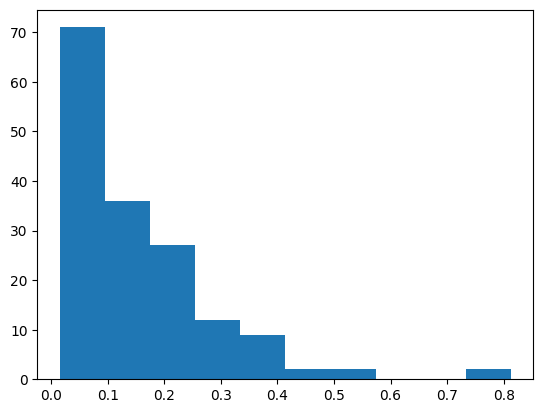

In [11]:
plt.hist(ratios)